In [12]:
using JSON
using DataFrames
using StatsPlots
using Turing
using LinearAlgebra
using Random


### Multi-level model using football match simulation as an example

In [2]:
## First, import the data and do some data wrangling

england_league = JSON.parsefile("./data/matches_England.json")

matches_df = DataFrame(home = [], away = [], score_home = [], score_away = [])

Row,home,away,score_home,score_away
,Any,Any,Any,Any


In [3]:
# example entry for each game in england_league:  "label" => "Burnley - AFC Bournemouth, 1 - 2"
matches = []
for match in england_league
    push!(matches, split(match["label"], ",")) # "Burnley - AFC Bournemouth" # "1 - 2"
end

for match in matches
    home, away = split(match[1], " - ")  # "Burnley" # "AFC Bournemouth" 
    score_home, score_away = split(match[2], " - ") # "1" # "2"
    push!(matches_df,[home, away, parse(Int,score_home), parse(Int,score_away)])
end

matches_df

teams = unique(collect(matches_df[:,1]))

20-element Vector{Any}:
 "Burnley"
 "Crystal Palace"
 "Huddersfield Town"
 "Liverpool"
 "Manchester United"
 "Newcastle United"
 "Southampton"
 "Swansea City"
 "Tottenham Hotspur"
 "West Ham United"
 "Manchester City"
 "Leicester City"
 "Chelsea"
 "Arsenal"
 "Everton"
 "AFC Bournemouth"
 "Watford"
 "West Bromwich Albion"
 "Stoke City"
 "Brighton & Hove Albion"

In [4]:
## Now, our model

@model function football_matches(home_teams, away_teams, score_home, score_away, teams)

    # Hyper priors
    μatt ~ Normal(0, 0.1)
    μdef ~ Normal(0, 0.1)
    σatt ~ Exponential(1)
    σdef ~ Exponential(1)
    home ~ Normal(0, 1)
        
    # Team-specific effects
    
    att = zeros(length(teams))
    def = zeros(length(teams))
    
    for i in 1:length(teams)
        att[i] ~ Normal(μatt, σatt)
        def[i] ~ Normal(μdef, σdef)
    end

    #att ~ filldist(Normal(μatt, σatt), length(teams))  # more compact than for-loops
    #def ~ filldist(Normal(μdef, σdef), length(teams))
    
    offset = mean(att) + mean(def)
    
    # the number of matches
    n_matches = length(home_teams)

    # scoring rates θ
    θ_home = Vector{Real}(undef, n_matches)     # or just θ_home = zeros(n_matches)
    θ_away = Vector{Real}(undef, n_matches)     # or just θ_away = zeros(n_matches)
        
    # Modeling score-rate and scores for each match
    for i in 1:n_matches
        # scoring rate
        home_team_idx = findfirst(isequal(home_teams[i]), teams)
        away_team_idx = findfirst(isequal(away_teams[i]), teams)

        θ_home[i] = home + att[home_team_idx] + def[away_team_idx] - offset
        θ_away[i] = att[away_team_idx] + def[home_team_idx] - offset

        # scores
        score_home[i] ~ Poisson(exp(θ_home[i]))  # To ensure positive λ for Poisson distribution
        score_away[i] ~ Poisson(exp(θ_away[i]))
    end
end

football_matches (generic function with 2 methods)

In [5]:
model = football_matches(matches_df[:,1], matches_df[:,2], matches_df[:,3], matches_df[:,4], teams);

posterior = sample(model, NUTS(), 3000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:43:18
Sampling   1%|▍                                         |  ETA: 0:27:45
Sampling   2%|▋                                         |  ETA: 0:21:47
Sampling   2%|▉                                         |  ETA: 0:19:05
Sampling   2%|█                                         |  ETA: 0:17:01
Sampling   3%|█▎                                        |  ETA: 0:16:13
Sampling   4%|█▌                                        |  ETA: 0:15:00
Sampling   4%|█▋                                        |  ETA: 0:13:49
Sampling   4%|█▉                                        |  ETA: 0:13:34
Sampling   5%|██▏                                       |  ETA: 0:13:00
Sampling   6%|██▎                                       |  ETA: 0:12:31
Sampling   

Chains MCMC chain (3000×57×1 Array{Float64, 3}):

Iterations        = 1001:1:4000
Number of chains  = 1
Samples per chain = 3000
Wall duration     = 325.82 seconds
Compute duration  = 325.82 seconds
parameters        = μatt, μdef, σatt, σdef, home, att[1], att[2], att[3], att[4], att[5], att[6], att[7], att[8], att[9], att[10], att[11], att[12], att[13], att[14], att[15], att[16], att[17], att[18], att[19], att[20], def[1], def[2], def[3], def[4], def[5], def[6], def[7], def[8], def[9], def[10], def[11], def[12], def[13], def[14], def[15], def[16], def[17], def[18], def[19], def[20]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

        μatt   -0.0020 

In [6]:
posterior_df=DataFrame(posterior)

Row,iteration,chain,μatt,μdef,σatt,σdef,home,att[1],att[2],att[3],att[4],att[5],att[6],att[7],att[8],att[9],att[10],att[11],att[12],att[13],att[14],att[15],att[16],att[17],att[18],att[19],att[20],def[1],def[2],def[3],def[4],def[5],def[6],def[7],def[8],def[9],def[10],def[11],def[12],def[13],def[14],def[15],def[16],def[17],def[18],def[19],def[20],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1001,1,0.078476,0.111009,0.366271,0.171321,0.357269,-0.1545,0.11469,-0.270093,0.574369,0.360482,-0.428532,-0.210461,-0.197796,0.567124,-0.0644401,0.745928,-0.00596369,0.445131,0.543613,-0.0733816,0.104695,-0.0961296,-0.286166,0.0156302,-0.507783,0.0767415,0.160227,0.371461,0.169802,-0.0508207,0.172373,0.370567,0.0951529,-0.00398078,0.205751,-0.276354,0.236249,-0.0380058,0.250615,0.0873599,0.376325,0.202213,0.217627,0.221163,0.334754,-1078.55,7.0,1.0,0.930106,-1078.55,1104.23,-0.0814506,0.229591,3.0,0.0,0.382644,0.382644
2,1002,1,-0.0763871,0.167484,0.352703,0.224884,0.377992,-0.377357,-0.286616,-0.659152,0.370324,0.297329,0.000382543,-0.262466,-0.726647,0.222623,0.029324,0.661794,0.277146,-0.00953135,0.175295,-0.124866,-0.248689,-0.0695553,-0.469811,-0.560726,-0.131152,0.0636769,0.351244,0.128827,-0.0368742,-0.167572,0.127105,0.0837893,0.415963,0.0976753,0.594925,0.181104,0.341441,0.237665,0.150802,0.514031,0.182362,0.476929,0.336534,0.460361,0.032902,-1085.61,7.0,1.0,0.697031,-1085.61,1103.27,0.624256,0.894627,3.0,0.0,0.382644,0.382644
3,1003,1,-0.00507011,0.246167,0.440977,0.201291,0.377818,-0.2366,0.0970641,-0.380199,0.529756,0.112064,-0.461554,-0.629838,-0.601168,0.320318,0.00484167,0.699437,0.0392341,0.361982,0.602192,-0.0166712,0.045002,-0.0490664,-0.32881,-0.182229,-0.48049,0.150683,0.321986,0.394222,0.160765,-0.264704,0.3066,0.336496,0.284162,-0.119043,0.316232,-0.105553,0.435354,0.207217,0.333599,0.412198,0.451909,0.436028,0.205254,0.482604,0.490306,-1080.25,7.0,1.0,0.993405,-1080.25,1104.9,-0.34452,-0.361778,3.0,0.0,0.382644,0.382644
4,1004,1,-0.0150203,0.21218,0.44747,0.308549,0.290122,-0.164072,-0.325317,-0.64978,0.586865,0.538694,0.222463,-0.232362,-0.36851,0.632703,0.0474723,0.857115,0.436445,0.228046,0.329553,-0.270918,0.0821573,0.101797,-0.425101,-0.0791556,-0.317029,-0.026883,0.169505,0.342018,0.150215,0.145044,0.158278,0.397346,0.282478,-0.307011,0.425919,-0.153001,0.496194,-0.0891482,0.4363,0.114456,0.322599,0.357247,0.424783,0.367825,0.0295185,-1091.13,7.0,1.0,0.396416,-1091.13,1113.4,1.10433,1.19337,3.0,0.0,0.382644,0.382644
5,1005,1,0.0164446,0.236434,0.323592,0.257407,0.330346,0.0623866,0.21543,-0.372985,0.469046,0.478982,0.126456,-0.322855,-0.434063,0.422575,0.202077,0.812884,0.189728,0.301264,0.546877,0.0890837,0.31409,0.0310391,-0.582788,-0.115289,-0.243874,0.0394098,0.441098,0.359208,-0.182554,-0.139682,0.0775109,0.344935,0.229589,-0.227882,0.629174,-0.372454,0.363132,0.315604,0.407057,0.248125,0.607736,0.421353,0.286658,0.331809,0.220249,-1084.85,7.0,1.0,0.945453,-1084.85,1115.45,-0.626328,-0.633814,3.0,0.0,0.382644,0.382644
6,1006,1,0.145557,0.0759257,0.45762,0.235948,0.318829,-0.57421,-0.195359,-0.136993,0.678514,0.317713,-0.187154,-0.257126,-0.143946,0.43087,0.274985,0.905508,0.244109,0.427708,0.578801,0.0660789,0.0941757,0.0632164,0.0468377,-0.0598044,-0.285973,-0.0898433,-0.0588579,0.311513,-0.0983084,-0.0913904,0.0244082,0.380143,0.0965021,0.0388047,0.289793,0.0126214,0.356924,0.0590227,0.123196,0.0926553,0.263042,0.52124

In [7]:
DataFrames.transform!(posterior_df, AsTable(Between("att[1]","att[20]")) => ByRow(mean) => :att_mean)
DataFrames.transform!(posterior_df, AsTable(Between("def[1]","def[20]")) => ByRow(mean) => :def_mean)
DataFrames.transform!(posterior_df, AsTable([:att_mean,:def_mean]) => ByRow(sum) => :offset)

Row,iteration,chain,μatt,μdef,σatt,σdef,home,att[1],att[2],att[3],att[4],att[5],att[6],att[7],att[8],att[9],att[10],att[11],att[12],att[13],att[14],att[15],att[16],att[17],att[18],att[19],att[20],def[1],def[2],def[3],def[4],def[5],def[6],def[7],def[8],def[9],def[10],def[11],def[12],def[13],def[14],def[15],def[16],def[17],def[18],def[19],def[20],lp,n_steps,is_accept,acceptance_rate,log_density,hamiltonian_energy,hamiltonian_energy_error,max_hamiltonian_energy_error,tree_depth,numerical_error,step_size,nom_step_size,att_mean,def_mean,offset
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1001,1,0.078476,0.111009,0.366271,0.171321,0.357269,-0.1545,0.11469,-0.270093,0.574369,0.360482,-0.428532,-0.210461,-0.197796,0.567124,-0.0644401,0.745928,-0.00596369,0.445131,0.543613,-0.0733816,0.104695,-0.0961296,-0.286166,0.0156302,-0.507783,0.0767415,0.160227,0.371461,0.169802,-0.0508207,0.172373,0.370567,0.0951529,-0.00398078,0.205751,-0.276354,0.236249,-0.0380058,0.250615,0.0873599,0.376325,0.202213,0.217627,0.221163,0.334754,-1078.55,7.0,1.0,0.930106,-1078.55,1104.23,-0.0814506,0.229591,3.0,0.0,0.382644,0.382644,0.0588208,0.158961,0.217782
2,1002,1,-0.0763871,0.167484,0.352703,0.224884,0.377992,-0.377357,-0.286616,-0.659152,0.370324,0.297329,0.000382543,-0.262466,-0.726647,0.222623,0.029324,0.661794,0.277146,-0.00953135,0.175295,-0.124866,-0.248689,-0.0695553,-0.469811,-0.560726,-0.131152,0.0636769,0.351244,0.128827,-0.0368742,-0.167572,0.127105,0.0837893,0.415963,0.0976753,0.594925,0.181104,0.341441,0.237665,0.150802,0.514031,0.182362,0.476929,0.336534,0.460361,0.032902,-1085.61,7.0,1.0,0.697031,-1085.61,1103.27,0.624256,0.894627,3.0,0.0,0.382644,0.382644,-0.0946175,0.228644,0.134027
3,1003,1,-0.00507011,0.246167,0.440977,0.201291,0.377818,-0.2366,0.0970641,-0.380199,0.529756,0.112064,-0.461554,-0.629838,-0.601168,0.320318,0.00484167,0.699437,0.0392341,0.361982,0.602192,-0.0166712,0.045002,-0.0490664,-0.32881,-0.182229,-0.48049,0.150683,0.321986,0.394222,0.160765,-0.264704,0.3066,0.336496,0.284162,-0.119043,0.316232,-0.105553,0.435354,0.207217,0.333599,0.412198,0.451909,0.436028,0.205254,0.482604,0.490306,-1080.25,7.0,1.0,0.993405,-1080.25,1104.9,-0.34452,-0.361778,3.0,0.0,0.382644,0.382644,-0.0277368,0.261816,0.234079
4,1004,1,-0.0150203,0.21218,0.44747,0.308549,0.290122,-0.164072,-0.325317,-0.64978,0.586865,0.538694,0.222463,-0.232362,-0.36851,0.632703,0.0474723,0.857115,0.436445,0.228046,0.329553,-0.270918,0.0821573,0.101797,-0.425101,-0.0791556,-0.317029,-0.026883,0.169505,0.342018,0.150215,0.145044,0.158278,0.397346,0.282478,-0.307011,0.425919,-0.153001,0.496194,-0.0891482,0.4363,0.114456,0.322599,0.357247,0.424783,0.367825,0.0295185,-1091.13,7.0,1.0,0.396416,-1091.13,1113.4,1.10433,1.19337,3.0,0.0,0.382644,0.382644,0.0615532,0.202184,0.263737
5,1005,1,0.0164446,0.236434,0.323592,0.257407,0.330346,0.0623866,0.21543,-0.372985,0.469046,0.478982,0.126456,-0.322855,-0.434063,0.422575,0.202077,0.812884,0.189728,0.301264,0.546877,0.0890837,0.31409,0.0310391,-0.582788,-0.115289,-0.243874,0.0394098,0.441098,0.359208,-0.182554,-0.139682,0.0775109,0.344935,0.229589,-0.227882,0.629174,-0.372454,0.363132,0.315604,0.407057,0.248125,0.607736,0.421353,0.286658,0.331809,0.220249,-1084.85,7.0,1.0,0.945453,-1084.85,1115.45,-0.626328,-0.633814,3.0,0.0,0.382644,0.382644,0.109503,0.220004,0.329507
6,1006,1,0.145557,0.0759257,0.45762,0.235948,0.318829,-0.57421,-0.195359,-0.136993,0.678514,0.317713,-0.187154,-0.257126,-0.143946,0.43087,0.274985,0.905508,0.244109,0.427708,0.578801,0.0660789,0.0941757,0.0632164,0.0468

In [8]:
# For this example, we are interested in a pair of teams (no need to use map for all teams)

teamA = "Manchester City"
teamB = "Manchester United"

teamA_id = findfirst(isequal(teamA), teams)
teamB_id = findfirst(isequal(teamB), teams)

teamA_att_post = posterior_df[:,"att[$teamA_id]"]
teamA_def_post = posterior_df[:,"def[$teamA_id]"]

teamB_att_post = posterior_df[:,"att[$teamB_id]"]
teamB_def_post = posterior_df[:,"def[$teamB_id]"]

3000-element Vector{Float64}:
 -0.050820673106887336
 -0.16757192717583197
 -0.26470411159452917
  0.1450440261068634
 -0.1396815496048601
 -0.0913904345504786
 -0.18443028447891568
 -0.2329647762435188
 -0.13924756168721714
 -0.1407189119125585
  ⋮
 -0.44602511248585774
 -0.30121327116911134
 -0.5631502347932151
 -0.44097463721232
 -0.8150637167695501
 -0.7038256530506207
 -0.5888429457810659
 -0.5483116096507531
 -0.5848164942224084

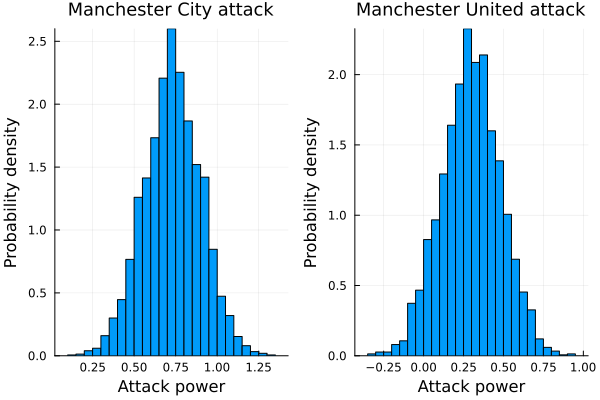

In [9]:
ha1 = histogram(teamA_att_post, title=teamA*" attack", titlefontsize = 12, legend=false, normalized=true);
ha2 = histogram(teamB_att_post, title=teamB*" attack", titlefontsize = 12, legend=false, normalized=true);
plot(ha1, ha2, layout=(1,2));
xlabel!("Attack power");
ylabel!("Probability density")

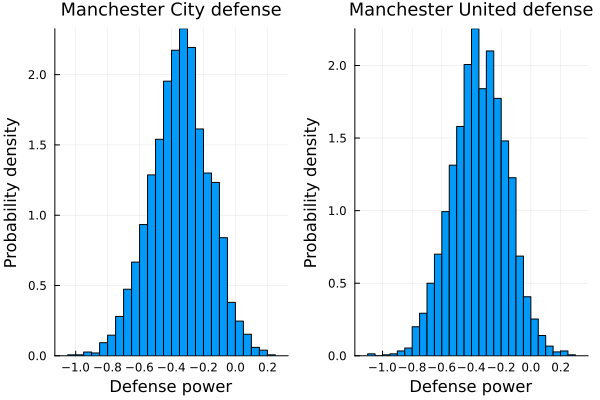

In [10]:
hd1 = histogram(teamA_def_post, title=teamA*" defense", titlefontsize = 12, legend=false, normalized=true);
hd2 = histogram(teamB_def_post, title=teamB*" defense", titlefontsize = 12, legend=false, normalized=true);
plot(hd1, hd2, layout=(1,2));
xlabel!("Defense power");
ylabel!("Probability density")

### Mini Project

Consult the lecture notes.

In [14]:
Random.seed!(1234)
# hint: let's simulate 500 hypothetical finals (then you will have a total of 3000*500 samples)

# first leg: teamA is the home team and teamB is the away team

θ_home = posterior_df[:,:home] + posterior_df[:,"att[$teamA_id]"] + posterior_df[:,"def[$teamB_id]"] - posterior_df[:,:offset]
#θ_away = 

teamA_score = rand.(Poisson.(exp.(θ_home)),500)
#teamB_score = 

# second leg: teamA is the away team and teamB is the home team

#θ_home = 
#θ_away = 

#teamA_score += rand.(Poisson.(exp.(θ_away)),500)  # add the first-leg result with the second-leg result
#teamB_score = 

# transform into long column vectors
teamA_score = vcat(teamA_score...)
#teamB_score = vcat(teamB_score...)


1500000-element Vector{Int64}:
 3
 2
 3
 3
 2
 2
 1
 2
 2
 3
 ⋮
 2
 2
 2
 4
 2
 1
 3
 1
 0